In [1]:
# @title Importing dependencies
import numpy
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

In [2]:
# @title Downloading MNIST dataset
mnist_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                            ]))
mnist_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                            ]))

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.62MB/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [3]:
# @title Binarise MNIST data
def binarise_mnist(mnist):
    mnist_bin = []
    for img, label in mnist:
        mnist_bin.append((torch.where(img < 0.5, 0.0, 1.0), label))
    return mnist_bin

In [4]:
X_train = binarise_mnist(mnist_train)
X_test = binarise_mnist(mnist_test)

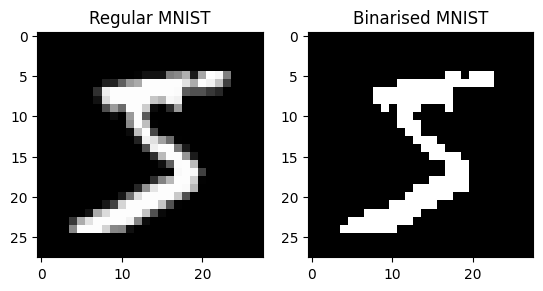

In [ ]:
# @title Visualise MNIST and binarised MNIST
import matplotlib.pyplot as plt

# Get an example image and label from mnist_train
img, label = mnist_train[0]

# Get the corresponding binarised image and label from X_train
binarised_img, binarised_label = X_train[0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Plot the regular MNIST image on the first subplot
axes[0].imshow(img.squeeze(), cmap='gray')
axes[0].set_title('Regular MNIST')

# Plot the binarised MNIST image on the second subplot
axes[1].imshow(binarised_img.squeeze(), cmap='gray')
axes[1].set_title('Binarised MNIST')

# Show the plot
plt.show()

### Defining Classes for Model Architecture

In [5]:
class MaskedConvolution2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type):
        super(MaskedConvolution2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.mask_type = mask_type
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size)
        self.create_mask()

    def create_mask(self):
        mask = torch.ones(self.kernel_size, self.kernel_size)
        mask[self.kernel_size // 2, self.kernel_size // 2:] = 0
        mask[self.kernel_size // 2 + 1:, :] = 0
        if self.mask_type == 'B':
            mask[self.kernel_size // 2, self.kernel_size // 2] = 1
        self.register_buffer('mask', mask)

    def forward(self, X):
        self.conv.weight.data = self.conv.weight.data * self.mask
        return self.conv(X)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_channels):
        super(ResidualBlock, self).__init__()
        self.hidden_channels = hidden_channels
        self.maskedconv1 = MaskedConvolution2D(2 * self.hidden_channels, self.hidden_channels, 1, 'A')
        self.maskedconv2 = MaskedConvolution2D(self.hidden_channels, self.hidden_channels, 3, 'B')
        self.maskedconv3 = MaskedConvolution2D(self.hidden_channels, 2 * self.hidden_channels, 1, 'B')
        self.relu = nn.ReLU()
        self.padding = nn.ZeroPad2d(1)

    def forward(self, X):
        out = self.maskedconv1(X)
        out = self.relu(out)
        out = self.padding(out)
        out = self.maskedconv2(out)
        out = self.relu(out)
        out = self.maskedconv3(out)
        out += X
        return out

In [14]:
class PixelCNN(nn.Module):
    def __init__(self, hidden_channels, out_hidden_channels, residual_blocks):
        super(PixelCNN, self).__init__()
        self.hidden_channels = hidden_channels
        self.out_hidden_channels = out_hidden_channels
        self.residual_blocks = residual_blocks

        layers = []
        layers.append(nn.ZeroPad2d(3))
        layers.append(MaskedConvolution2D(1, 2 * self.hidden_channels, 7, 'A'))
        for _ in range(residual_blocks):
            layers.append(ResidualBlock(self.hidden_channels))
        # layers.append(MaskedConvolution2D(2 * self.hidden_channels, self.out_hidden_channels, 3, 'B'))
        layers.append(nn.ReLU())
        layers.append(MaskedConvolution2D(2 * self.hidden_channels, self.out_hidden_channels, 1, 'B'))
        layers.append(nn.ReLU())
        layers.append(MaskedConvolution2D(self.out_hidden_channels, 1, 1, 'B'))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

Use padding to keep spatial dims the same!

In [ ]:
model = PixelCNN(hidden_channels=4, out_hidden_channels=8, residual_blocks=2)
img, label = X_train[0]
y = model(img)
img.shape, y.shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

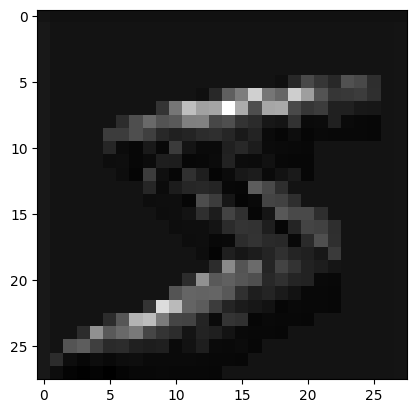

In [ ]:
# Plot y
plt.imshow(y.squeeze().detach().numpy(), cmap='gray')
plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
# @title Creating DataLoader for binarised MNIST
from torch.utils.data import DataLoader

train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
test_loader = DataLoader(X_test, batch_size=32, shuffle=False)

In [19]:
# @title Train
torch.manual_seed(42)
epochs = 20

model = PixelCNN(hidden_channels=128, out_hidden_channels=128, residual_blocks=15)
criterion = nn.BCELoss()
optimiser = torch.optim.RMSprop(model.parameters(), lr=0.001)
model.to(device)

model.train()
for epoch in range(epochs):
    for img, _ in train_loader:
        img = img.to(device)

        optimiser.zero_grad()
        y = model(img)
        loss = criterion(y, img)
        loss.backward()
        optimiser.step()
    print(f"Epoch: {epoch+1}, Loss:, {loss.item()}")

KeyboardInterrupt: 